# Supervised learning models to predicting football matches outcomes

### Notebook by [Martim Pinto da Silva](https://github.com/motapinto), [Luis Ramos](https://github.com/luispramos), [Francisco Gonçalves](https://github.com/kiko-g)
#### Supported by [Luis Paulo Reis](https://web.fe.up.pt/~lpreis/)
#### [Faculdade de Engenharia da Universidade do Porto](https://sigarra.up.pt/feup/en/web_page.inicial)

#### It is recommended to [view this notebook in nbviewer](https://nbviewer.ipython.org/github.com/motapinto/football-classification-predications/blob/master/src/Supervised%20Learning%20Models.ipynb) for the best overall experience
#### You can also execute the code on this notebook using [Jupyter Notebook](https://jupyter.org/) or [Binder](https://mybinder.org/)(no local installation required)


## Table of contents
1. [Introduction](#Introduction)
2. [Required libraries and models](#Required-libraries-and-models)
3. [The problem domain](#The-problem-domain)
4. [Step 1: Data analysis](#Step-1:-Data-analysis)
5. [Step 2: Classification](#Step-2:-Classification)
6. [Step 3: Matches outcomes](#Step-3:-Matches-outcomes)
7. [Interpretation and Evaluation](#)
8. [Conclusion](#Conclusion)
9. [Resources](#Resources)

## Introduction
[go back to the top](#Table-of-content)
adasd
asd

## Required libraries and models
[go back to the top](#Table-of-content)

### Libraries
If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

**NumPy**: Provides a fast numerical array structure and helper functions.

**pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.

**scikit-learn**: The essential Machine Learning package, for a variaty of supervised learning models, in Python.

**tensorflow**: The essential Machine Learning package, for deep learning, in Python.

**matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.

### Models
Regarding the supervised learning models, we are using [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), [Nearest Neighbors](), [DecisionTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html), and [Deep Learning Neural Networks](https://keras.io/guides/sequential_model/)


In [1]:
# Primary libraries
from time import time
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# Neural Networks
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
# Measures
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder  

Using TensorFlow backend.


## The problem domain
[go back to the top](#Table-of-content)

The first step to any data analysis project is to define the question or problem we're looking to solve, and to define a measure (or set of measures) for our success at solving that task. The data analysis checklist has us answer a handful of questions to accomplish that, so let's work through those questions.

#### Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

> We are trying to design a predictive model capable of accurately predicting if the home team will either win, lose or draw, i.e., predict the outcome of football matche based on a set of measurements, including player ratings, team ratings, team average stats(possession, corners, shoots), team style(pressing, possession, defending, counter attacking, speed of play, ..) and team match history(previous games)

#### Did you define the metric for success before beginning?

> Let's do that now. Since we're performing classification, we can use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) — the fraction of correctly classified matches — to quantify how well our model is performing. Knowing that most bookkeepers predict matches with an accuracy of 50%, we will try to match or beat that value. We will also use a confusion matrix, and analyse the precision, recall and f1-score. 
    
#### Did you consider whether the question could be answered with the available data?",

> The data provided has information about more than 25k matches across multiple leagues. Even though the usability isn't great, after some processing and cleansing of the data, we will be able to predict matches with great confidence. To answer the question, yes, we have more than enough data to analyse football matches..

## Step 1: Data analysis

The first step we have, is to look at the data, and after extracting, analyse it. We know that most datasets can contain minor issues, so we have to search for  possible null or not defined values, and if so how do we proceed? Do we remove an entire row of a Dataframe? Maybe we just need to purify and substitute it's value? This analysis is done below.

Before analysing the data, we need to first extract it. For that we use multiple methods to have a cleaner code :smiley:

### Defining FIFA related methods

In [2]:
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.iloc[0]    


def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        
        fifa_data = pd.read_pickle(path)
        
    else:
        
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data


def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    #Check if only overall player stats are desired
    if get_overall == True:
        
        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        
        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    #Return data
    return data

### Defining matches related methods

In [3]:
''' Derives a label for a given match. '''
def get_match_outcome(match):
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    outcome = pd.DataFrame()
    outcome.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match outcome  
    if home_goals > away_goals:
        outcome.loc[0,'outcome'] = "Win"
    if home_goals == away_goals:
        outcome.loc[0,'outcome'] = "Draw"
    if home_goals < away_goals:
        outcome.loc[0,'outcome'] = "Defeat"

    #Return outcome        
    return outcome.loc[0]


''' Get the last x matches of a given team. '''
def get_last_matches(matches, date, team, x = 10):
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches
    
    
''' Get the last team stats of a given team. '''
def get_last_team_stats(team_id, date, team_stats):
    #Filter team stats
    all_team_stats = teams_stats[teams_stats['team_api_id'] == team_id]
           
    #Filter last stats from team
    last_team_stats = all_team_stats[all_team_stats.date < date].sort_values(by='date', ascending=False)
    if last_team_stats.empty:
        last_team_stats = all_team_stats[all_team_stats.date > date].sort_values(by='date', ascending=True)

    #Return last matches
    return last_team_stats.iloc[0:1,:]
    
    
''' Get the last x matches of two given teams. '''
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches


''' Get the goals[home & away] of a specfic team from a set of matches. '''
def get_goals(matches, team):
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    return total_goals


''' Get the goals[home & away] conceided of a specfic team from a set of matches. '''
def get_goals_conceided(matches, team):
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals


''' Get the number of wins of a specfic team from a set of matches. '''
def get_wins(matches, team):
    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    return total_wins 


''' Create match specific features for a given match. '''
def get_match_features(match, matches, teams_stats, x = 10):
    #Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
     # Gets home and away team_stats
    home_team_stats = get_last_team_stats(home_team, date, teams_stats);
    away_team_stats = get_last_team_stats(away_team, date, teams_stats);
    
    #Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 5)
    matches_away_team = get_last_matches(matches, date, away_team, x = 5)
    
    #Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    #Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    #Define result data frame
    result = pd.DataFrame()
    
    #Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id
    
    #Create match features and team stats
    if(not home_team_stats.empty):
        result.loc[0, 'home_team_buildUpPlaySpeed'] = home_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'home_team_buildUpPlayPassing'] = home_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationPassing'] = home_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'home_team_chanceCreationCrossing'] = home_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'home_team_chanceCreationShooting'] = home_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'home_team_defencePressure'] = home_team_stats['defencePressure'].values[0]
        result.loc[0, 'home_team_defenceAggression'] = home_team_stats['defenceAggression'].values[0]
        result.loc[0, 'home_team_defenceTeamWidth'] = home_team_stats['defenceTeamWidth'].values[0]
        result.loc[0, 'home_team_avg_shots'] = home_team_stats['avg_shots'].values[0]
        result.loc[0, 'home_team_avg_corners'] = home_team_stats['avg_corners'].values[0]
        result.loc[0, 'home_team_avg_crosses'] = away_team_stats['avg_crosses'].values[0]
    
    if(not away_team_stats.empty):
        result.loc[0, 'away_team_buildUpPlaySpeed'] = away_team_stats['buildUpPlaySpeed'].values[0]
        result.loc[0, 'away_team_buildUpPlayPassing'] = away_team_stats['buildUpPlayPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationPassing'] = away_team_stats['chanceCreationPassing'].values[0]
        result.loc[0, 'away_team_chanceCreationCrossing'] = away_team_stats['chanceCreationCrossing'].values[0]
        result.loc[0, 'away_team_chanceCreationShooting'] = away_team_stats['chanceCreationShooting'].values[0]
        result.loc[0, 'away_team_defencePressure'] = away_team_stats['defencePressure'].values[0]
        result.loc[0, 'away_team_defenceAggression'] = away_team_stats['defenceAggression'].values[0]
        result.loc[0, 'away_team_defenceTeamWidth'] = away_team_stats['defenceTeamWidth'].values[0]
        result.loc[0, 'away_team_avg_shots'] = away_team_stats['avg_shots'].values[0]
        result.loc[0, 'away_team_avg_corners'] = away_team_stats['avg_corners'].values[0]
        result.loc[0, 'away_team_avg_crosses'] = away_team_stats['avg_crosses'].values[0]
    
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
    #Return match features
    return result.loc[0]

''' Create and aggregate features and labels for all matches. '''
def get_features(matches, teams_stats, fifa, x = 10, get_overall = False):  
    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    #Get match features for all matches
    match_stats = matches.apply(lambda i: get_match_features(i, matches, teams_stats, x = 10), axis = 1)
    
    #Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    
    #Create match outcomes
    outcomes = matches.apply(get_match_outcome, axis = 1)

    #Merges features and outcomes into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, outcomes, on = 'match_api_id', how = 'left')
    
    #Drop NA values
    features.dropna(inplace = True)
    
    #Return preprocessed data
    return features

### Extracting data from the database

In [4]:
with sqlite3.connect("../dataset/database.sqlite") as con:
    matches = pd.read_sql_query("SELECT * from Match", con)
    team_attributes = pd.read_sql_query("SELECT distinct * from Team_Attributes",con)
    player = pd.read_sql_query("SELECT * from Player",con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",con)

### Matches
We start by cleaning the match data 

In [5]:
viable_matches = matches.sample(n=5000)
viable_matches.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.00000,4641.000000,...,3267.000000,4327.000000,4327.000000,4327.000000,2691.000000,2691.000000,2691.000000,2689.000000,2689.000000,2689.00000
mean,13033.577000,11781.398800,11781.398800,18.212800,1.198785e+06,10180.273000,10453.943400,1.532200,1.13800,0.999354,...,4.593636,2.673600,3.908003,4.852170,2.508729,3.649142,4.320505,2.513630,3.660792,4.38418
std,7509.251595,7562.187243,7562.187243,10.483468,4.923964e+05,15816.358038,17302.596073,1.275025,1.13948,0.025419,...,3.606653,1.994801,1.277863,4.283268,1.525000,0.861271,2.961994,1.569632,0.858887,3.18578
min,15.000000,1.000000,1.000000,1.000000,4.831290e+05,1601.000000,1601.000000,0.000000,0.00000,0.000000,...,1.100000,1.040000,2.400000,1.080000,1.060000,1.850000,1.120000,1.070000,1.910000,1.12000
25%,6519.750000,4769.000000,4769.000000,9.000000,8.299008e+05,8472.000000,8475.000000,1.000000,0.00000,1.000000,...,2.575000,1.700000,3.300000,2.550000,1.670000,3.200000,2.500000,1.670000,3.250000,2.50000
50%,13053.500000,10257.000000,10257.000000,18.000000,1.189724e+06,8696.000000,8697.000000,1.000000,1.00000,1.000000,...,3.500000,2.150000,3.500000,3.500000,2.100000,3.300000,3.400000,2.100000,3.400000,3.40000
75%,19536.750000,17642.000000,17642.000000,27.000000,1.709846e+06,9908.000000,9927.000000,2.000000,2.00000,1.000000,...,5.000000,2.800000,4.000000,5.250000,2.650000,3.750000,5.000000,2.620000,3.750000,5.00000
max,25975.000000,24558.000000,24558.000000,38.000000,2.216672e+06,274581.000000,274581.000000,9.000000,9.00000,1.000000,...,34.000000,31.000000,18.000000,46.000000,17.000000,11.000000,26.000000,17.000000,11.000000,26.00000


Looking at the match data we can see that most columns have 5000 values. This means we are analysing this number of matches from the database, selected randomly. We could test with all the matches(25k+) but if that were the case, then testing would take more than 1 hour. We can also see that some bookkeeper is missing. Having done a detailed analysis on it, we saw some inconsistencys and so we will not consider them.

In [6]:
viable_matches.drop(['B365H', 'B365D', 'B365A', 
                      'BWH', 'BWD', 'BWA', 
                      'IWH', 'IWD', 'IWA',  
                      'LBH', 'LBD', 'LBA',
                      'PSH', 'PSD', 'PSA',
                      'WHH', 'WHD', 'WHA',
                      'SJH', 'SJD', 'SJA',
                      'VCH', 'VCD', 'VCA', 
                      'GBH', 'GBD', 'GBA', 
                      'BSH', 'BSD', 'BSA'], 
                    inplace = True, axis = 1)

We also need to consider that some of these matches may not be on the team attributes that we will clean after this. In that case, we need to remove any matches that does not contain any team stats information, since **mean imputation** would't work in these case.

We also need to remove some rows that do not contain any information about the position of the players for some matches

In [7]:
teams_stats = team_attributes
viable_matches = viable_matches.dropna(inplace=False)

home_teams = viable_matches['home_team_api_id'].isin(teams_stats['team_api_id'].tolist())
away_teams = viable_matches['away_team_api_id'].isin(teams_stats['team_api_id'].tolist())
viable_matches = viable_matches[home_teams & away_teams]

viable_matches.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
count,2525.000000,2525.000000,2525.000000,2525.000000,2.525000e+03,2525.000000,2525.000000,2525.000000,2525.000000,2525.0,...,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000,2525.000000
mean,11280.854257,9702.574257,9702.574257,19.349703,1.279114e+06,9399.263762,9585.414257,1.537822,1.138614,1.0,...,102951.136238,84568.712871,88350.719604,103789.153267,94668.493861,94692.083960,104223.991683,106641.662970,99618.317624,93818.664950
std,7044.639345,6999.614809,6999.614809,10.655984,4.864181e+05,7214.229577,8469.013751,1.271041,1.129051,0.0,...,110487.233275,99155.474757,99209.756887,115546.917651,107107.819816,111907.690415,116750.893110,112817.977152,110016.389033,102428.279678
min,1730.000000,1729.000000,1729.000000,1.000000,4.890430e+05,4087.000000,4087.000000,0.000000,0.000000,1.0,...,9079.000000,2752.000000,2752.000000,2790.000000,2805.000000,2805.000000,2802.000000,2802.000000,2802.000000,2983.000000
25%,6068.000000,4769.000000,4769.000000,10.000000,8.572260e+05,8533.000000,8533.000000,1.000000,0.000000,1.0,...,31306.000000,27660.000000,29471.000000,31921.000000,30724.000000,30631.000000,30966.000000,33337.000000,30981.000000,30988.000000
50%,9706.000000,7809.000000,7809.000000,19.000000,1.239730e+06,8686.000000,8686.000000,1.000000,1.000000,1.0,...,41105.000000,37508.000000,39027.000000,41167.000000,39854.000000,39644.000000,41540.000000,41865.000000,40707.000000,40176.000000
75%,13261.000000,10257.000000,10257.000000,28.000000,1.724212e+06,9873.000000,9875.000000,2.000000,2.000000,1.0,...,157252.000000,103470.000000,114044.000000,154938.000000,141082.000000,134236.000000,154233.000000,161015.000000,150292.000000,141161.000000
max,25949.000000,24558.000000,24558.000000,38.000000,2.060637e+06,208931.000000,208931.000000,9.000000,9.000000,1.0,...,715642.000000,696443.000000,696443.000000,720738.000000,704523.000000,693171.000000,710807.000000,722766.000000,722766.000000,684978.000000


### Team Stats - Team Attributes

In [8]:
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,489.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,11.545869,9.678290,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,62.000000,55.000000,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


Looking at the description of team attributes we can see that there are a lot of values missing from the column buildUpPlayDribbling, and all the other values seem to have the right amout of rows. This means that there are a lot of values with 'Nan' on this column.

It's not ideal that we just drop those rows. Seems like the missing data on the column is systematic - all of the missing values are in the same column - this error could potentially bias our analysis

One way to deal with missing values is **mean imputation**. If we know that the values for a measurement fall in a certain range, we can fill in empty values with the average of that measure.


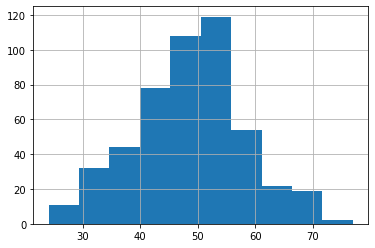

In [9]:
teams_stats['buildUpPlayDribbling'].hist();

We can see that most buildUpPlayDribbling values fall within the 51 - 55 range, so let's fill in these entries with the average measured buildUpPlaySpeed

In [10]:
build_up_play_drib_avg = teams_stats['buildUpPlayDribbling'].mean()
# mean imputation
teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull()), 'buildUpPlayDribbling'] = build_up_play_drib_avg
# showing new values
teams_stats.loc[teams_stats['buildUpPlayDribbling'] == build_up_play_drib_avg].head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,48.607362,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,48.607362,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,48.607362,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,6,77,8485,2012-02-22 00:00:00,58,Balanced,48.607362,Little,62,Mixed,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,7,77,8485,2013-09-20 00:00:00,62,Balanced,48.607362,Little,45,Mixed,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover


In [11]:
teams_stats.loc[(teams_stats['buildUpPlayDribbling'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the buildUpPlayDribbling. After that, we decided to select only continuous data, i.e, select only columns that "store" numerical values that we will provide to the input of the supervised learning models.

In [12]:
teams_stats.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', 
    'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass',  
    'chanceCreationShootingClass','chanceCreationPositioningClass','defencePressureClass', 'defenceAggressionClass', 
    'defenceTeamWidthClass','defenceDefenderLineClass'], inplace = True, axis = 1)

teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000


### Team Stats - Shots
After cleaning the match data we need to consider adding some more stats to each match. We will start by adding the average of the number of shots per team. The number of shots consists on the sum of the shots on target and the shots of target. After merging all the information to teams_stats we have to analyse the data again.

In [13]:
shots_off = pd.read_csv("../dataset/shotoff_detail.csv")
shots_on = pd.read_csv("../dataset/shoton_detail.csv")
shots = pd.concat([shots_off[['match_id', 'team']], shots_on[['match_id', 'team']]])

total_shots = shots["team"].value_counts()
total_matches = shots.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_shots in total_shots.iteritems():
    n_matches = total_matches[index]
    avg_shots = n_shots / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_shots'] = avg_shots
    
teams_stats.loc[(teams_stats['avg_shots'].isnull())].head()

c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (0,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (1,7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots
0,1,434,9930,2010-02-22 00:00:00,60,48.607362,50,60,65,55,50,55,45,NaN
1,2,434,9930,2014-09-19 00:00:00,52,48.000000,56,54,63,64,47,44,54,NaN
2,3,434,9930,2015-09-10 00:00:00,47,41.000000,54,54,63,64,47,44,54,NaN
3,4,77,8485,2010-02-22 00:00:00,70,48.607362,70,70,70,70,60,70,70,NaN
4,5,77,8485,2011-02-22 00:00:00,47,48.607362,52,53,48,52,47,47,52,NaN


As we can see, there are a lot of Nan values on the avg_shots column. This represents teams that did not have shots data on this dataset. Instead of removing thoose rows, and give less input to our models we need again to do **mean imputation** and deal with these values

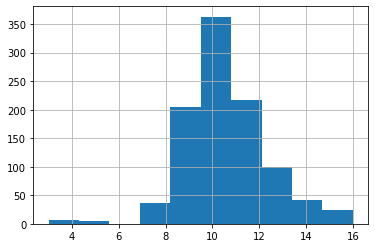

In [14]:
teams_stats['avg_shots'].hist();

We can see that most avg_shots values fall within the 7 - 14 range, so let's fill in these entries with the average measured avg_shots

In [15]:
shots_avg_team_avg = teams_stats['avg_shots'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_shots'].isnull()), 'avg_shots'] = shots_avg_team_avg
# showing new values
teams_stats.loc[teams_stats['avg_shots'] == shots_avg_team_avg].head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots
0,1,434,9930,2010-02-22 00:00:00,60,48.607362,50,60,65,55,50,55,45,10.579949
1,2,434,9930,2014-09-19 00:00:00,52,48.000000,56,54,63,64,47,44,54,10.579949
2,3,434,9930,2015-09-10 00:00:00,47,41.000000,54,54,63,64,47,44,54,10.579949
3,4,77,8485,2010-02-22 00:00:00,70,48.607362,70,70,70,70,60,70,70,10.579949
4,5,77,8485,2011-02-22 00:00:00,47,48.607362,52,53,48,52,47,47,52,10.579949


In [16]:
teams_stats.loc[(teams_stats['avg_shots'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the avg_shots.

### Team Stats - Possession

We will now add another stat, the ball possession. One of the more important statistics to predict the match results. If we analyse the most dominating teams usually control the ball possession very easily. We can see first that the csv have repeated values for the ball possession, for each match, based on the elapsed time of the match. We need to remove all the values that do not refer to the 90 minutes mark of the elapsed time.

In [17]:
# possessions read, cleanup and merge
possessions_data = pd.read_csv("../dataset/possession_detail.csv")
last_possessions = possessions_data.loc[(possessions_data['elapsed'] == 90)]
last_possessions = last_possessions[['match_id', 'homepos', 'awaypos']]

c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (1,2,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


After reading it, we need to see if the number of possession data we have available is enough to be considered

In [18]:
# get the ids of the home_team and away_team to be able to join with teams later
possessions = pd.DataFrame(columns=['team', 'possession', 'match'])
for index, row in last_possessions.iterrows():
    match = viable_matches.loc[viable_matches['id'] == row['match_id'], ['home_team_api_id', 'away_team_api_id']]
    if match.empty is True:
        continue
    hometeam = match['home_team_api_id'].values[0]
    awayteam = match['away_team_api_id'].values[0]
    possessions = possessions.append({'team': hometeam, 'possession': row['homepos'], 'match': row['match_id']}, ignore_index=True)
    possessions = possessions.append({'team': awayteam, 'possession': row['awaypos'], 'match': row['match_id']}, ignore_index=True)

total_possessions = possessions.groupby(by=['team'])['possession'].sum()
total_matches = possessions.drop_duplicates(['team', 'match'])["team"].value_counts()
    
total_possessions.to_frame().describe()

,possession
count,161.000000
mean,664.596273
std,584.669772
min,27.000000
25%,209.000000
50%,505.000000
75%,953.000000
max,2923.000000


Since the number of average possession regarding the number of viable matches is very low it doesn't make any sense to do **mean imputation** in this instance. After carefully consideration, we decided to scrap this attribute, even though this attribute as a very important meaning. This reflects the poor usability of this dataset

### Team Stats - Corners

In [19]:
corners_data = pd.read_csv("../dataset/corner_detail.csv")
corners = corners_data[['match_id', 'team']]

total_corners = corners["team"].value_counts()
total_matches = corners.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_corners in total_shots.iteritems():
    n_matches = total_matches[index]
    avg_corners = n_corners / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_corners'] = avg_corners
    
teams_stats.describe()

c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,997.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,10.807166
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,1.916837
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,9.700000
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,10.591837
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,11.526316
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,21.000000


As we can see, there are a lot of Nan values on the avg_corners column. This represents teams that did not have corners data on this dataset. Instead of removing thoose rows, and give less input to our models we need again to do **mean imputation** and deal with these values

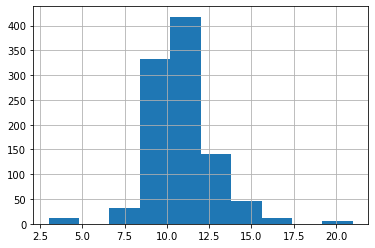

In [20]:
teams_stats['avg_corners'].hist();

We can see that most avg_corners values fall within the 8.5 - 12 range, so let's fill in these entries with the average measured avg_corners

In [21]:
corners_avg_team_avg = teams_stats['avg_corners'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_corners'].isnull()), 'avg_corners'] = corners_avg_team_avg
# showing new values
teams_stats.loc[teams_stats['avg_corners'] == corners_avg_team_avg].head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners
0,1,434,9930,2010-02-22 00:00:00,60,48.607362,50,60,65,55,50,55,45,10.579949,10.807166
1,2,434,9930,2014-09-19 00:00:00,52,48.000000,56,54,63,64,47,44,54,10.579949,10.807166
2,3,434,9930,2015-09-10 00:00:00,47,41.000000,54,54,63,64,47,44,54,10.579949,10.807166
3,4,77,8485,2010-02-22 00:00:00,70,48.607362,70,70,70,70,60,70,70,10.579949,10.807166
4,5,77,8485,2011-02-22 00:00:00,47,48.607362,52,53,48,52,47,47,52,10.579949,10.807166


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the avg_corners.

In [22]:
teams_stats.loc[(teams_stats['avg_corners'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners


In [23]:
teams_stats.describe()

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,10.807166
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,1.584839
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,10.119718
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,10.807166
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,11.105263
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,21.000000


### Team Stats - Crosses

In [24]:
crosses_data = pd.read_csv("../dataset/cross_detail.csv")

crosses = crosses_data[['match_id', 'team']]
total_crosses = crosses["team"].value_counts()
total_matches = crosses.drop_duplicates(['match_id', 'team'])["team"].value_counts()

for index, n_crosses in total_crosses.iteritems():
    n_matches = total_matches[index]
    avg_crosses = n_crosses / n_matches
    teams_stats.loc[teams_stats['team_api_id'] == index, 'avg_crosses'] = avg_crosses

teams_stats.describe()

c:\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (8,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,997.000000
mean,729.500000,17706.982167,9995.727023,52.462277,48.607362,48.490398,52.165295,53.731824,53.969136,46.017147,49.251029,52.185871,10.579949,10.807166,15.888237
std,421.032659,39179.857739,13264.869900,11.545869,5.601170,10.896101,10.360793,11.086796,10.327566,10.227225,9.738028,9.574712,1.495291,1.584839,2.815376
min,1.000000,1.000000,1601.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000,3.000000,3.000000,1.500000
25%,365.250000,110.000000,8457.750000,45.000000,48.607362,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000,9.947368,10.119718,14.358974
50%,729.500000,485.000000,8674.000000,52.000000,48.607362,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000,10.579949,10.807166,15.750000
75%,1093.750000,1900.000000,9904.000000,62.000000,48.607362,55.000000,59.000000,62.000000,61.000000,51.000000,55.000000,58.000000,10.960000,11.105263,17.782895
max,1458.000000,112513.000000,274581.000000,80.000000,77.000000,80.000000,80.000000,80.000000,80.000000,72.000000,72.000000,73.000000,16.000000,21.000000,27.000000


As we can see, there are a lot of Nan values on the avg_crosses column. This represents teams that did not have crosses data on this dataset. Instead of removing thoose rows, and give less input to our models we need again to do **mean imputation** and deal with these values

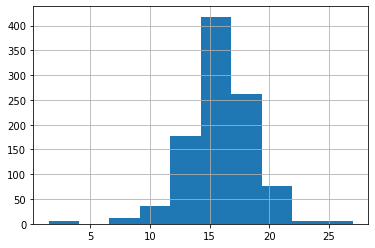

In [25]:
teams_stats['avg_crosses'].hist();

We can see that most avg_corners values fall within the 12.5 - 17.5 range, so let's fill in these entries with the average measured avg_corners

In [26]:
crosses_avg_team_avg = teams_stats['avg_crosses'].mean()
# mean imputation
teams_stats.loc[(teams_stats['avg_crosses'].isnull()), 'avg_crosses'] = crosses_avg_team_avg
# showing new values
teams_stats.loc[teams_stats['avg_crosses'] == crosses_avg_team_avg].head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses
0,1,434,9930,2010-02-22 00:00:00,60,48.607362,50,60,65,55,50,55,45,10.579949,10.807166,15.888237
1,2,434,9930,2014-09-19 00:00:00,52,48.000000,56,54,63,64,47,44,54,10.579949,10.807166,15.888237
2,3,434,9930,2015-09-10 00:00:00,47,41.000000,54,54,63,64,47,44,54,10.579949,10.807166,15.888237
3,4,77,8485,2010-02-22 00:00:00,70,48.607362,70,70,70,70,60,70,70,10.579949,10.807166,15.888237
4,5,77,8485,2011-02-22 00:00:00,47,48.607362,52,53,48,52,47,47,52,10.579949,10.807166,15.888237


Having done the **mean imputation** for team_attributes we can see that there are no longer missing values for the avg_crosses.

In [27]:
teams_stats.loc[(teams_stats['avg_crosses'].isnull())]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,avg_shots,avg_corners,avg_crosses


In [28]:
fifa_data = get_fifa_data(viable_matches, player_attributes, None, data_exists = False)

Fifa data collected in 4.5 minutes


In [29]:
# Creates features and labels based on the provided data
viables = get_features(viable_matches, teams_stats, fifa_data, 10, False)
inputs = viables.drop('match_api_id', axis=1)
outcomes = inputs.loc[:, 'outcome']

To improve the overall measures of the supersived learning models we need to normalize our features before training our models.

In [30]:
# all features except outcomes
features = inputs.drop('outcome', axis=1)
features.iloc[:,:] = Normalizer(norm='l1').fit_transform(features)
features.head()

,home_team_buildUpPlaySpeed,home_team_buildUpPlayPassing,home_team_chanceCreationPassing,home_team_chanceCreationCrossing,home_team_chanceCreationShooting,home_team_defencePressure,home_team_defenceAggression,home_team_defenceTeamWidth,home_team_avg_shots,home_team_avg_corners,...,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating
0,0.020770,0.024297,0.023122,0.026649,0.020378,0.016459,0.020378,0.025473,0.004285,0.004342,...,0.030176,0.032135,0.028608,0.029784,0.031743,0.029784,0.031743,0.031351,0.032527,0.031351
1,0.014573,0.012491,0.012491,0.012491,0.022900,0.016655,0.027064,0.022900,0.004039,0.004039,...,0.032060,0.031227,0.024565,0.033309,0.032060,0.027480,0.030395,0.033725,0.034558,0.031227
2,0.025096,0.027026,0.027026,0.027026,0.021235,0.013513,0.027026,0.013513,0.003639,0.003737,...,0.028184,0.028571,0.023938,0.025096,0.028957,0.027412,0.028184,0.028957,0.028184,0.026640
3,0.016608,0.022005,0.016608,0.029478,0.019929,0.014947,0.017023,0.021590,0.003944,0.004163,...,0.029063,0.029478,0.029894,0.027818,0.028233,0.030309,0.030309,0.029894,0.031554,0.029478
4,0.018041,0.020296,0.019169,0.019920,0.024055,0.018041,0.018417,0.019920,0.004609,0.004720,...,0.027813,0.029317,0.029317,0.029317,0.028941,0.030069,0.031196,0.031196,0.031196,0.026310


In [31]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size = 0.2, shuffle = True, stratify = outcomes)

In [32]:
# Training and Evaluating Models
def train_model(clf, X_train, y_train):
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    print ('Training took {} seconds'.format(end - start))
    
def train_model_nn(clf, X_train, y_train):
    start = time()
    clf.fit(X_train, y_train, epochs=150, batch_size=313)
    end = time()
    print ('Training took {} seconds'.format(end - start))
    
def predict_outcome(clf, X_test, y_test):
    start = time()
    y_predict = clf.predict(X_test)
    end = time()
    print ('Predictions took {} seconds'.format(end - start))
    predict_metrics(y_test, y_predict)
    
def predict_metrics(y_test, y_predict):
    labels = ['Win', 'Draw', 'Defeat']
    
    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_predict, labels, normalize='true')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier\n')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Accuracy score for training set: ", metrics.accuracy_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict, average='macro'))
    print("Precision: ", metrics.precision_score(y_test, y_predict, average='macro'))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict, average='macro'))
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    train_model(clf, X_train, y_train)
    predict_outcome(clf, X_test, y_test)
    
def train_predict_nn(clf, X_train, y_train, X_test, y_test):
    train_model_nn(clf, X_train, y_train)
    predict_outcome(clf, X_test, y_test)

## KNN

Training took 0.05465888977050781 seconds
Predictions took 0.2576603889465332 seconds


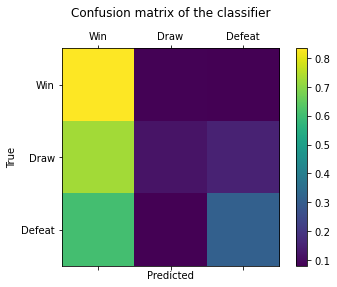

Accuracy score for training set:  0.502970297029703
Recall:  0.4217427627038611
Precision:  0.4611442656979761
F1 Score:  0.4026770436606502


In [33]:
clf = KNeighborsClassifier(n_neighbors=100)
train_predict(clf, X_train, y_train, X_test, y_test)

ValueError: query data dimension must match training data dimension

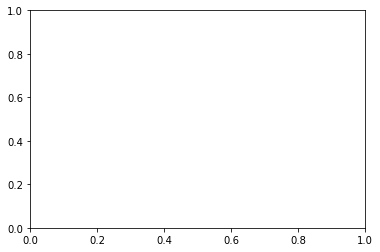

In [45]:
from mlxtend.plotting import plot_decision_regions
def knn_vizualition(X_train, y_train):
    plot_decision_regions(X_train, y_train, clf=clf, legend=2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('KNN')
    plt.show
    
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
x = X_train.to_numpy()
x = pca.fit_transform(x)

le = LabelEncoder()
y = le.fit_transform(y_train)



knn_vizualition(x, y)
    

Training took 0.05172586441040039 seconds
Predictions took 0.0009760856628417969 seconds


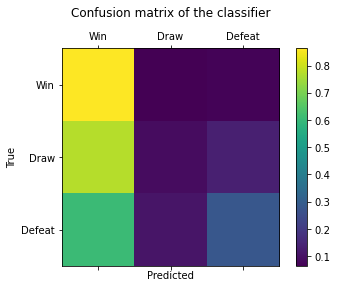

Accuracy score for training set:  0.500990099009901
Recall:  0.4120273742699372
Precision:  0.4440071727989466
F1 Score:  0.38451416860999227


In [46]:
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', splitter='random', max_depth=5)
train_predict(clf, X_train, y_train, X_test, y_test)

Training took 0.4636235237121582 seconds
Predictions took 0.04584527015686035 seconds


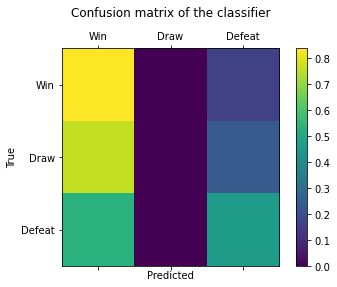

Accuracy score for training set:  0.5148514851485149
Recall:  0.43379165118295554
Precision:  0.33530460903032006
F1 Score:  0.37284070653054613


c:\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
clf = SVC(coef0=5, kernel='poly')
train_predict(clf, X_train, y_train, X_test, y_test)

Training took 0.005826234817504883 seconds
Predictions took 0.001953601837158203 seconds


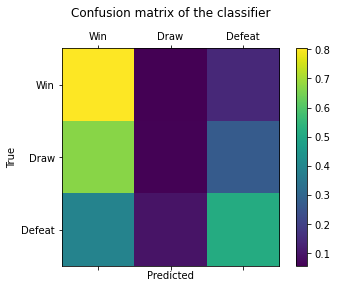

Accuracy score for training set:  0.5287128712871287
Recall:  0.45935397766061375
Precision:  0.4368042685352087
F1 Score:  0.42402882526790825


In [48]:
clf = GaussianNB(var_smoothing=1.1)
train_predict(clf, X_train, y_train, X_test, y_test)

Training took 1.841829538345337 seconds
Predictions took 0.026356935501098633 seconds


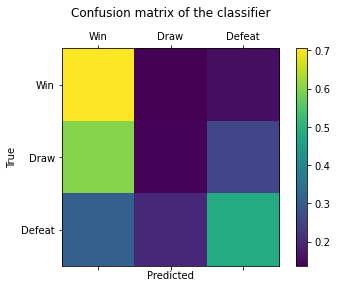

Accuracy score for training set:  0.497029702970297
Recall:  0.4444975314540532
Precision:  0.4329767473858008
F1 Score:  0.4323121458138855


In [49]:
clf = XGBClassifier()
train_predict(clf, X_train, y_train, X_test, y_test)

In [50]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train)
y_test2 = le.fit_transform(y_test)
y_train2 = np_utils.to_categorical(y_train2)
y_test2 = np_utils.to_categorical(y_test2)

#clf = Sequential()
#clf.add(Dense(16, input_shape=(39,), activation='sigmoid'))
#clf.add(Dense(8, activation='sigmoid'))
#clf.add(Dense(1, activation='sigmoid'))

#print(clf.summary())


visible = Input(shape=(56,))
hidden1 = Dense(500, activation='relu')(visible)
hidden2 = Dense(100, activation='relu')(hidden1)
hidden3 = Dense(50, activation='relu')(hidden2)
output = Dense(3, activation='softmax')(hidden3)

clf = Model(inputs=visible, outputs=output)

#clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
clf.compile(optimizer='adagrad', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


train_predict_nn(clf, X_train, y_train2, X_test, y_test)

pred_train = clf.predict(X_train)
scores = clf.evaluate(X_train, y_train2, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test = clf.predict(X_test)
scores2 = clf.evaluate(X_test, y_test2, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Epoch 1/150
2020/2020 [==============================] - 0s 155us/step - loss: 1.0744 - accuracy: 0.4376
Epoch 2/150
2020/2020 [==============================] - 0s 14us/step - loss: 1.0636 - accuracy: 0.4629
Epoch 3/150
2020/2020 [==============================] - 0s 15us/step - loss: 1.0648 - accuracy: 0.4629
Epoch 4/150
2020/2020 [==============================] - 0s 13us/step - loss: 1.0654 - accuracy: 0.4629
Epoch 5/150
2020/2020 [==============================] - 0s 15us/step - loss: 1.0623 - accuracy: 0.4629
Epoch 6/150
2020/2020 [==============================] - 0s 14us/step - loss: 1.0623 - accuracy: 0.4629
Epoch 7/150
2020/2020 [==============================] - 0s 15us/step - loss: 1.0618 - accuracy: 0.4629
Epoch 8/150
2020/2020 [==============================] - 0s 14us/step - loss: 1.0620 - accuracy: 0.4629
Epoch 9/150
2020/2020 [==============================] - 0s 14us/step - loss: 1.0623 - accuracy: 0.4629
Epoch 10/150
2020/2020 [==============================] - 0s 14

2020/2020 [==============================] - 0s 14us/step - loss: 1.0084 - accuracy: 0.4960
Epoch 80/150
2020/2020 [==============================] - 0s 14us/step - loss: 0.9994 - accuracy: 0.5099
Epoch 81/150
2020/2020 [==============================] - 0s 15us/step - loss: 0.9985 - accuracy: 0.5045
Epoch 82/150
2020/2020 [==============================] - 0s 18us/step - loss: 1.0068 - accuracy: 0.5050
Epoch 83/150
2020/2020 [==============================] - 0s 19us/step - loss: 1.0028 - accuracy: 0.5084
Epoch 84/150
2020/2020 [==============================] - 0s 15us/step - loss: 1.0292 - accuracy: 0.4738
Epoch 85/150
2020/2020 [==============================] - 0s 15us/step - loss: 1.0043 - accuracy: 0.5094
Epoch 86/150
2020/2020 [==============================] - 0s 19us/step - loss: 0.9986 - accuracy: 0.5099
Epoch 87/150
2020/2020 [==============================] - 0s 19us/step - loss: 1.0019 - accuracy: 0.5069
Epoch 88/150
2020/2020 [==============================] - 0s 17us/st

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets